# Evaluation Notebook

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [11]:
data = 'wind_hourly_age'

results_dir = os.path.join('results', data)
result_files = os.listdir(results_dir)
# pickle files where training was performed on single dataset sequentially
sims = [f for f in result_files if (f.endswith('.pkl')) & ('cl' not in f) & ('fl' not in f)]
# pickle files where training was performed on concatenated datasets (centralized learning)
cl_sims = [f for f in result_files if 'cl' in f]
cl_sims.sort()
# pickle files for federated learning simulations
fl_sims = [f for f in result_files if 'fl' in f]
persistence_files = [f for f in result_files if 'persistence' in f]
persistence_file = None
if persistence_files:
    persistence_file = persistence_files[0]
    pers = pd.read_csv(os.path.join(results_dir, persistence_file))

In [3]:
def concatenate_results(results_dir: str,
                        results: list,
                        index_cols: list,
                        get_skill: bool = False,
                        pers: pd.DataFrame = pd.DataFrame(),
                        sort_skill: bool = False) -> pd.DataFrame:
    indices = defaultdict(list)
    metrics = []
    if not results:
        print('No data found.')
        return None
    # initialize the dict list
    for file in results:  # Iterate through all result files
        # Load the data
        with open(os.path.join(results_dir, file), 'rb') as f:
            pkl = pickle.load(f)
        df = pkl['evaluation']
        df.reset_index(inplace=True)
        if get_skill:
            df= pd.merge(df, pers[['RMSE', 'key', 'output_dim', 'freq']],
               on=['key', 'output_dim', 'freq'],
               how='left',
               suffixes=('', '_p'))
            df['Skill'] = 1 - df.RMSE / df.RMSE_p
            df.drop('RMSE_p', axis=1, inplace=True)
        for col in index_cols:
            indices[col].append(df[col].iloc[0])
        df.drop(index_cols, axis=1, inplace=True)
        #if len(df) != 1:
        #    df.drop('key', axis=1, inplace=True)
        metric = df.mean(axis=0)
        metrics.append(metric)
    df = pd.DataFrame(metrics, columns=metric.index)
    df_index = pd.DataFrame(indices)
    df = pd.concat([df, df_index], axis=1)
    df.sort_values(['output_dim', 'freq', 'Models'], inplace=True)
    if sort_skill:
        df.sort_values(['Skill'], ascending=False, inplace=True)
    return df

def read_sim(results_dir, sim):
    try:
        with open(os.path.join(results_dir, sim), 'rb') as f:
            sim_results = pickle.load(f)
    except:
        sim_results = None
    return sim_results

Federated simulation analysis - N datasets : 1 model

In [4]:
index_cols = ['Models', 'output_dim', 'freq', 't_0', 'strategy', 'personalization']
df_fl = concatenate_results(results_dir=results_dir,
                            results=fl_sims,
                            index_cols=index_cols)
df_fl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models', 'strategy', 'personalization']].round(4).set_index('Models')

No data found.


TypeError: 'NoneType' object is not subscriptable

Centralized simulation analysis - N datasets : 1 model

In [12]:
index_cols = ['Models', 'output_dim', 'freq', 't_0', 'key']
df_cl = concatenate_results(results_dir=results_dir,
                             get_skill=False,
                             #pers=pers,
                             results=cl_sims,
                             index_cols=index_cols)
df_cl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models', 'output_dim', 'key']].round(4).set_index('Models')

,R^2,RMSE,MAE,Skill,output_dim,key
Models,,,,,,
tcn-gru,0.6278,0.0421,0.0209,0.5274,48.0,synth_00164.csv
tcn-gru,0.6354,0.0637,0.0286,0.5286,48.0,synth_03362.csv
tcn-gru,0.7385,0.1426,0.0932,0.6120,48.0,synth_03631.csv
tcn-gru,0.6524,0.1274,0.0678,0.5384,48.0,synth_07370.csv
tft,0.5691,0.1051,0.0593,0.5015,48.0,synth_07412.csv


Individual simulation analysis

In [4]:
pd.set_option('display.max_rows', None)
fontsize = 12

In [5]:
cl_sim = cl_sims[1]
fl_sim = None#fl_sims[0]

In [6]:
cl_results = read_sim(results_dir, cl_sim)
fl_results = read_sim(results_dir, fl_sim)

In [7]:
cl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
synth_07412.csv,0.5947,0.0992,0.0401,0.4998
synth_03631.csv,0.5917,0.1294,0.0784,0.5295
synth_03287.csv,0.7561,0.1111,0.0670,0.6237
synth_04177.csv,0.7654,0.0721,0.0337,0.6119
synth_03513.csv,0.5704,0.0569,0.0310,0.4628
synth_00183.csv,0.5751,0.2486,0.1623,0.5027
synth_01200.csv,0.7903,0.1103,0.0615,0.6496
synth_00198.csv,0.6905,0.0585,0.0247,0.5788
synth_00953.csv,0.6216,0.1810,0.1160,0.5056


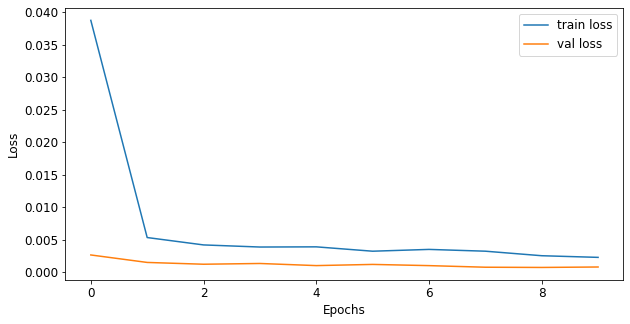

In [21]:
fig = plt.figure(figsize=(10, 5))

plt.plot(cl_results['history']['loss'], label='train loss')
plt.plot(cl_results['history']['val_loss'], label='val loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [9]:
fl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
station00.csv,0.9320,0.0597,0.0239,0.5601
station01.csv,0.9709,0.0519,0.0303,0.6646
station02.csv,0.9773,0.0388,0.0228,0.7357
station04.csv,0.9668,0.0700,0.0412,0.7133
station06.csv,0.9588,0.0431,0.0247,0.6057
station07.csv,0.9625,0.0478,0.0242,0.6704
station08.csv,0.9834,0.0324,0.0192,0.7807


In [12]:
fig = plt.figure(figsize=(10, 5))

plt.plot(fl_results['history']['metrics_aggregated']['train_loss'], label='train_loss')
plt.plot(fl_results['history']['metrics_aggregated']['eval_loss'], label='val_loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>